In [1]:
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer import Layer
from math import sqrt
import math
import numpy as np
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from Energy_Models import Models as mo
from Data import preprocess_data as pr

In [2]:
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [5]:
df.shape

(2075259, 7)

In [6]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [7]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [8]:
fill_missing(df.values)

In [9]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
# Compute remaining active power
df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)

In [11]:
# descriptive statistics
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [12]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [13]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [14]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [15]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [16]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [17]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_UNI_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (1008, 1, 7) and ouput feature (1008,)


In [18]:
# Split the testing data into input features and out feature
X_test, Y_test = pr.convert_UNI_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (432, 1, 7) and ouput feature (432,)


In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [20]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
X_train = X_train.reshape((X_train.shape[0], 1, 1, n_features))
X_test = X_test.reshape((X_test.shape[0], 1, 1, n_features))
model=mo.TD(n_steps,n_features,n_outputs).getModel()
model.compile(optimizer='adam', loss ='mae')
history = model.fit(X_train , Y_train, epochs=100, batch_size=128, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/100
7/7 [==============================] - 2s 75ms/step - loss: 0.2684 - val_loss: 0.1443
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1732 - val_loss: 0.0725
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1089 - val_loss: 0.1440
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1184 - val_loss: 0.0887
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1065 - val_loss: 0.0703
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1064 - val_loss: 0.0749
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.1003 - val_loss: 0.0866
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1021 - val_loss: 0.0749
Epoch 9/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0979 - val_loss: 0.0689
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0955 - val_loss: 0.0692
Epoch 11/100
7/7 [==========

In [21]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0733
evaluation : 0.073 
14/14 [==============================] - 0s 1ms/step - loss: 0.0577
evaluation : 0.058 


In [22]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

14/14 [==============================] - 0s 1ms/step


In [23]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.103 
Train MSE value    : 0.011 
Train R2 value     : 0.471 
Train MAPE value   : 83099523169.955 
Train RMLSE value  : 0.006 
Train MAE value    : 0.073 
---------------------------------------------
Test RMSE value   : 0.078 
Test MSE value   : 0.006 
Test R2 value   : 0.452 
Test MAPE value  : 0.221 
Test RMLSE value  : 0.003 
Test MAE value : 0.058 


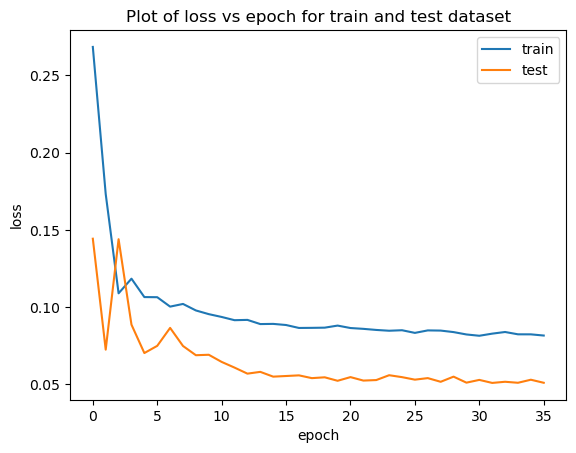

In [24]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [42]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [43]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [44]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_Multi_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (982, 21, 7) and ouput feature (982, 7)


In [45]:
X_test, Y_test = pr.convert_Multi_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (406, 21, 7) and ouput feature (406, 7)


In [46]:
n_steps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
X_train = X_train.reshape((X_train.shape[0],1,21, n_features))
X_test = X_test.reshape((X_test.shape[0],1, 21, n_features))
model = mo.TD(n_steps,n_features,n_outputs).getModel()
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=200, batch_size=512, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/200
2/2 [==============================] - 2s 408ms/step - loss: 0.1029 - val_loss: 0.0397
Epoch 2/200
2/2 [==============================] - 0s 43ms/step - loss: 0.0724 - val_loss: 0.0220
Epoch 3/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0452 - val_loss: 0.0179
Epoch 4/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0333 - val_loss: 0.0254
Epoch 5/200
2/2 [==============================] - 0s 38ms/step - loss: 0.0329 - val_loss: 0.0175
Epoch 6/200
2/2 [==============================] - 0s 37ms/step - loss: 0.0250 - val_loss: 0.0102
Epoch 7/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0198 - val_loss: 0.0082
Epoch 8/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0199 - val_loss: 0.0083
Epoch 9/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0213 - val_loss: 0.0086
Epoch 10/200
2/2 [==============================] - 0s 41ms/step - loss: 0.0205 - val_loss: 0.0089
Epoch 11/200
2/2 [

Epoch 84/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0108 - val_loss: 0.0062
Epoch 85/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0106 - val_loss: 0.0062
Epoch 86/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 87/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0105 - val_loss: 0.0068
Epoch 88/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0104 - val_loss: 0.0070
Epoch 89/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 90/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0102 - val_loss: 0.0065
Epoch 91/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0106 - val_loss: 0.0071
Epoch 92/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0104 - val_loss: 0.0069
Epoch 93/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 94/2

In [47]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

31/31 [==============================] - 0s 2ms/step - loss: 0.0091
evaluation : 0.009 
13/13 [==============================] - 0s 2ms/step - loss: 0.0083
evaluation : 0.008 


In [48]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

13/13 [==============================] - 0s 2ms/step


In [49]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.095 
Train MSE value    : 0.009 
Train R2 value     : 0.517 
Train MAPE value   : 234429386422.531 
Train RMLSE value  : 0.005 
Train MAE value    : 0.072 
---------------------------------------------
Test RMSE value   : 0.091 
Test MSE value   : 0.008 
Test R2 value   : 0.282 
Test MAPE value  : 0.248 
Test RMLSE value  : 0.005 
Test MAE value : 0.069 


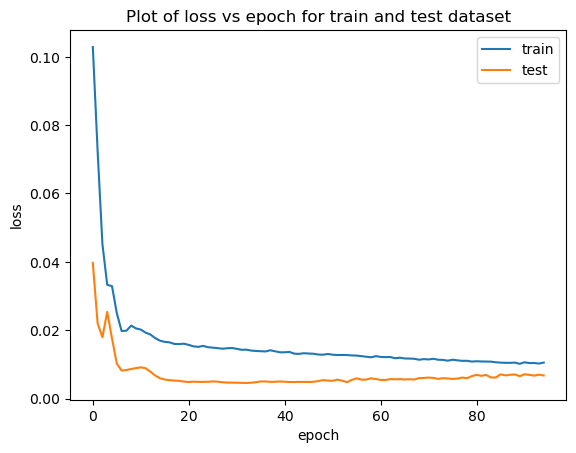

In [50]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()